In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import skimage.transform
from sklearn.model_selection import train_test_split

In [2]:
def read_pictures(directory='train/'):
    with open('files_list.txt') as f:
        files_list = f.readlines()
    files_list = [(directory+i.strip()) for i in files_list]
    return files_list

In [3]:
input_shape = (128, 128, 3)
files_list = read_pictures('preprocessed_images/')
# files_list = read_pictures()

In [4]:
def preprocess_img(img):
    return skimage.transform.resize(img, input_shape)

In [5]:
def get_dataset(preprocess = True):
    X = []
    y = []
    for i in tqdm.tqdm(files_list):
        if preprocess:
            X.append(preprocess_img(plt.imread(i)))
        else:
            X.append(plt.imread(i))
            
        if 'cat' in i:
            y.append([1, 0])
        else:
            y.append([0, 1])
    return X, y

In [6]:
def save_preprocessed_images(images):
    for i, name in tqdm.tqdm(zip(images, files_list)):
        plt.imsave(f'preprocessed_images/{name.split("/")[-1]}', i)

In [7]:
X, y = get_dataset(preprocess=False)

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:31<00:00, 272.43it/s]


In [8]:
# save_preprocessed_images(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

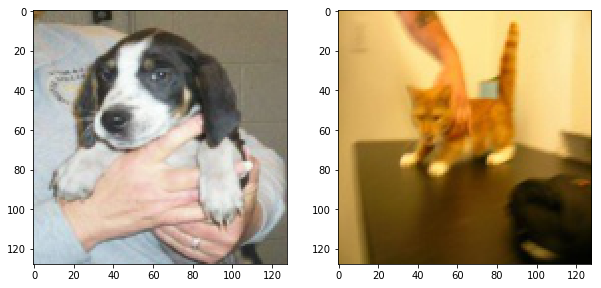

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X[12502]);
plt.subplot(122)
plt.imshow(X[0])
plt.show()

In [11]:
def inference(inp):
    with tf.name_scope('classificator'):
        with tf.name_scope('convolution'):
            layer = tf.layers.conv2d(inp, 32, 6)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.conv2d(layer, 16, 6)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.conv2d(layer, 8, 3)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.conv2d(layer, 4, 3)
            layer = tf.layers.flatten(layer)

        with tf.name_scope('dense'):
            layer = tf.layers.dense(layer, 64, activation=tf.nn.relu)
            layer = tf.layers.dense(layer, 32, activation=tf.nn.relu)
            layer = tf.layers.dense(layer, 2)
            
    return layer

In [48]:
def training(sess, X_train, y_train, X_test, y_test, epochs=100, batch_size=64):
    with tf.name_scope('network_input'):
        x_input = tf.placeholder(tf.float32, shape=(None, 128, 128, 3), name='features')
        y_input = tf.placeholder(tf.float32, shape=(None, 2))
    
    with tf.variable_scope('cnn', reuse=tf.AUTO_REUSE):
        outputs = inference(x_input)
        logits = tf.nn.softmax(outputs, name='output')
    
    with tf.name_scope('training'):
        loss = tf.losses.softmax_cross_entropy(y_input, outputs)
        optimize = tf.train.AdamOptimizer().minimize(loss)
        
    with tf.name_scope('accuracy_measurement'):
        accuracy, acc_update = tf.metrics.accuracy(y_input, logits)
        
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    saver = tf.train.Saver()
    train_writer = tf.summary.FileWriter('logs/', sess.graph)
    
    for i in range(epochs):
        for j in tqdm.trange(int(len(X_train)/batch_size)):
            point = j*batch_size
            ls, _ = sess.run([loss, optimize], feed_dict={x_input: X_train[point:point+batch_size], y_input: y_train[point:point+batch_size]})
        
        if i%(np.ceil(i/10))==0:
            for j in range(int(len(X_test)/batch_size)):
                point = j*batch_size
                _, acc = sess.run([accuracy, acc_update], feed_dict={x_input: X_test[point:point+batch_size], y_input: y_test[point:point+batch_size]})

                # Don't ask me, I do not know why this is necessary
            acc = 1-acc
            print(f'Test accuracy: {acc*100}%\tTraining loss: {ls}')
    
    saver.save(sess, 'saved_model/test_classifier.ckpt')
    

In [49]:
def predict(sess, img):
    x_input = tf.placeholder(tf.float32, shape=(None, 128, 128, 3))
    with tf.variable_scope('cnn', reuse=tf.AUTO_REUSE):
        outputs = inference(x_input)
        logits = tf.nn.softmax(outputs)
    
    return sess.run(logits, feed_dict={x_input: img})[0]

In [50]:
tf.reset_default_graph()
sess = tf.Session()
training(sess, X_train, y_train, X_test, y_test, epochs=5)
print(predict(sess, [X[0]]))

100%|████████████████████████████████| 273/273 [00:06<00:00, 41.97it/s]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
100%|████████████████████████████████| 273/273 [00:06<00:00, 42.74it/s]


Test accuracy: 0.9999332264924305	Training loss: 0.6127445101737976


100%|████████████████████████████████| 273/273 [00:06<00:00, 42.82it/s]


Test accuracy: 0.9999666132462153	Training loss: 0.5347073078155518


100%|████████████████████████████████| 273/273 [00:06<00:00, 42.68it/s]


Test accuracy: 0.9999777421653562	Training loss: 0.4741083085536957


100%|████████████████████████████████| 273/273 [00:06<00:00, 41.35it/s]


Test accuracy: 0.9999833066231076	Training loss: 0.4323309063911438
[0.36857784 0.6314222 ]


In [15]:
saver = tf.train.Saver()
saver.save(sess, 'saved_model/classifier.ckpt')

'saved_model/classifier.ckpt'

In [46]:
with tf.Graph().as_default():
    inp = tf.placeholder(tf.float32, shape=(None, 128, 128, 3), name='network_input')
    with tf.variable_scope('cnn', reuse=True):
        model = inference(inp)
        saver = tf.train.Saver()
        saver.save(sess, 'saved_model/classifier.ckpt')


ValueError: Variable cnn/conv2d/kernel does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=tf.AUTO_REUSE in VarScope?

In [45]:
inp = tf.placeholder(tf.float32, shape=(None, 128, 128, 3), name='network_input')

with tf.variable_scope('cnn', reuse=True):
    model = inference(inp)
    saver = tf.train.Saver()
    saver.save(sess, 'saved_model/classifier.ckpt')